In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc

import sys
sys.path.append('../')

TEXT_COLOR = 'w'
FACECOLOR = '#373d4b'
mpl.rcParams['axes.facecolor'] = '#373d4b'
mpl.rcParams['text.color'] = TEXT_COLOR
mpl.rcParams['axes.labelcolor'] = TEXT_COLOR
mpl.rcParams['xtick.color'] = TEXT_COLOR
mpl.rcParams['ytick.color'] = TEXT_COLOR

from melanoma.core.losses import BCELabelSmoothingLoss
from melanoma.data.dataset import MelanomaDataset
from melanoma.data.augmentation import MelanomaAugmentor
from melanoma.utils.data_utils import load_data

In [19]:
import os
import skimage.io
import numpy as np
import torch
from copy import deepcopy
from collections import defaultdict
from torch.utils.data import Dataset

from utils import data_utils


class MelanomaDataset(Dataset):
    """Melanoma dataset."""
    def __init__(self,
                 root,
                 df,
                 target_col='target',
                 img_format='jpg',
                 augmentor=None,
                 norm_cols=None,
                 fp_16=False,
                 seed=None):
        self.root = root
        self.df = df
        self.augmentor = augmentor
        self.target_col = target_col
        self.img_format = img_format
        self.norm_cols = norm_cols
        self._seed = seed
        self._fp_16 = fp_16
        self._dtype = 'float16' if self._fp_16 else 'float32'
        self._dtype_torch = torch.float16 if self._fp_16 else torch.float32
        self._random_state = np.random.RandomState(self._seed)
        self.image_ids = self.df['image_name'].values.tolist()
        if self.target_col is not None:
            self.labels = df[self.target_col].values.tolist()
            self.training = True
        else:
            self.labels = None
            self.training = False

        self.files = None
        self.image_id_to_filepath = None

        self._set_image_id_to_filepaths()
        self._prepare_args()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        return self.labels[index]

    def _prepare_args(self):
        pass

    def _set_image_id_to_filepaths(self):
        self.image_id_to_filepath = defaultdict(list)
        for image_id in self.image_ids:
            self.image_id_to_filepath[image_id] = os.path.join(self.root, f'{image_id}.{self.img_format}')

    def _set_files(self):
        self.files = [fp for fps in self.image_id_to_filepaths.values() for fp in fps]

    def preprocess(self, img, **kwargs):
        img = np.asarray(img) / 255.
        if self.augmentor is None:
            return img
        else:
            return self.augmentor(img, **kwargs)

    def get_labels(self):
        return self.labels

    def get_image_ids(self):
        return self.image_ids

    def reset_state(self, seed=None):
        """Reset dataset random state for bagging + mutltiprocessing"""
        self._random_state = np.random.RandomState(seed)

In [10]:
from melanoma.data.dataset import MelanomaDataset

In [20]:
image_map={
    '2020':'../data/ISIC_2020/224x224_jpg_100_4/train/',
    '2019': '../data/ISIC_2019/224x224_jpg_100_4/train/'
}
df_train = load_data('../data/train.csv', 
                     duplicate_path='../data/sus/2020_Challenge_duplicates.csv', 
                     external_filepaths=['../data/external_data/isic_2019.csv'],
                     image_map=image_map
                    )
df_train['image_dir'] = '../data/ISIC_2020/224x224_jpg_100_4/train/'
ds = MelanomaDataset('../data/ISIC_2020/224x224_jpg_100_4/train/', df_train)

Adding external data from ../data/external_data/isic_2019.csv


In [21]:
from torch.utils.data import DataLoader
from melanoma.data.samplers import BatchStratifiedSampler,ImbalancedSampler
from tqdm import tqdm

# None

In [22]:
batch_size = 64
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

targets = []
for y in tqdm(dl):
    targets.append(y.numpy())
    
props = [sum(targets[i])/len(targets[i]) for i in range(len(targets))]

100%|██████████| 906/906 [00:00<00:00, 30099.80it/s]


mean   : 0.0879
std    : 0.0335
median : 0.0781


(array([ 11.,  45., 222., 184., 142., 223.,  34.,  39.,   4.,   2.]),
 array([0.      , 0.021875, 0.04375 , 0.065625, 0.0875  , 0.109375,
        0.13125 , 0.153125, 0.175   , 0.196875, 0.21875 ]),
 <BarContainer object of 10 artists>)

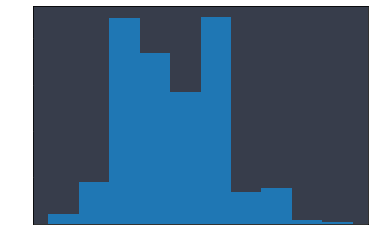

In [10]:
print(f'mean   : {np.mean(props):.4f}')
print(f'std    : {np.std(props):.4f}')
print(f'median : {np.median(props):.4f}')
plt.hist(props)

# Batch stratified

In [2]:
from torch.utils.data import Sampler

In [33]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

def stratify_batches(indices,                                                                                                                                                                              
                     labels,                                                                                                                                                                               
                     batch_size,                                                                                                                                                                           
                     drop_last=False,                                                                                                                                                                      
                     random_state=6969):                                                                                                                                                                   
    """Returns a list of indices stratified by `labels` where each stratification is                                                                                                                       
    of size `bathc_size`                                                                                                                                                                                   
    """                                                                                                                                                                                                    
    strat_indices = []                                                                                                                                                                                     
                                                                                                                                                                                                           
    num_batches = int(np.ceil(len(indices) / batch_size))                                                                                                                                                  
    remainder = len(indices) % batch_size                                                                                                                                                                  
    num_batches = num_batches - 1 if remainder > 0 else num_batches         
    print(remainder)
                                                                                                                                                                                                           
    if remainder > 0:                                                                                                                                                                                      
        remainder_indices = []                                                                                                                                                                             
        remainder_labels = []                                                                                                                                                                              
        rs = np.random.RandomState(random_state)                                                                                                                                                                      
        last_idx = rs.choice(indices, size=remainder, replace=False)                                                                                                                                       
        for idx in indices:                                                                                                                                                                                
            if idx not in last_idx:                                                                                                                                                                        
                remainder_indices.append(idx)                                                                                                                                                              
                remainder_labels.append(labels[idx])                                                                                                                                                       
    else:                                                                                                                                                                                                  
        remainder_indices = indices                                                                                                                                                                        
        remainder_labels = labels                                                                                                                                                                          
        last_idx = []                                                                                                                                                                                      
                                                                                                                                                                                                           
    skf = StratifiedKFold(n_splits=num_batches,                                                                                                                                                            
                          shuffle=True,                                                                                                                                                                    
                          random_state=random_state)
                                                                                                                                                                                             
    for _, batch_idx in skf.split(remainder_indices, remainder_labels):
        strat_indices.append([remainder_indices[idx] for idx in batch_idx])
#         strat_indices.extend([remainder_indices[idx] for idx in batch_idx])

    strat_indices = [strat_indices[i] for i in np.random.choice(range(len(strat_indices)), len(strat_indices))]
    if not drop_last:                                                                                                                                                                                      
        strat_indices.append(last_idx)                                                                                                                                                                     

    return [i for indices in strat_indices for i in indices]

# def stratify_batches(indices,
#                      labels,
#                      batch_size,
#                      drop_last=False,
#                      random_state=None):
#     """Returns a list of indices stratified by `labels` where each stratification is
#     of size `bathc_size`
#     """
#     strat_indices = []

#     num_batches = int(np.ceil(len(indices) / batch_size))
#     remainder = len(indices) % batch_size
#     num_batches = num_batches - 1 if remainder > 0 else num_batches

#     if remainder > 0:
#         remainder_indices = []
#         remainder_labels = []
#         rs = np.random.RandomState(random_state)
#         last_idx = rs.choice(indices, size=remainder, replace=False)
#         for idx in indices:
#             if idx not in last_idx:
#                 remainder_indices.append(idx)
#                 remainder_labels.append(labels[idx])
#     else:
#         remainder_indices = indices
#         remainder_labels = labels
#         last_idx = []

#     skf = StratifiedKFold(n_splits=num_batches,
#                           shuffle=True,
#                           random_state=random_state)

#     for _, batch_idx in skf.split(remainder_indices, remainder_labels):
#         strat_indices.extend([remainder_indices[idx] for idx in batch_idx])

#     if not drop_last:
#         strat_indices.extend(last_idx)

#     return strat_indices

In [34]:
batch_size =64
batches = stratify_batches(range(len(ds)), ds.get_labels(), batch_size=batch_size)

48


In [32]:
batches[:3]

[[187,
  992,
  1766,
  2131,
  2406,
  4081,
  4753,
  9997,
  11299,
  11425,
  13784,
  14368,
  15665,
  17128,
  17309,
  17771,
  18430,
  19905,
  20539,
  21113,
  21815,
  21820,
  22669,
  22837,
  23175,
  24304,
  24921,
  25092,
  26076,
  26926,
  27465,
  27809,
  28557,
  31521,
  32280,
  33913,
  34017,
  34354,
  35312,
  36617,
  39491,
  39713,
  39958,
  40479,
  41124,
  41580,
  41835,
  43789,
  45338,
  45478,
  45982,
  46670,
  47245,
  48014,
  49414,
  50147,
  50746,
  51424,
  52726,
  53105,
  53796,
  54647,
  56085,
  56668],
 [928,
  2074,
  5231,
  6436,
  7314,
  8816,
  8956,
  12020,
  12562,
  14135,
  14776,
  16984,
  17577,
  17943,
  20319,
  20491,
  22145,
  23967,
  24148,
  24339,
  25211,
  25999,
  26363,
  28271,
  28991,
  29359,
  29473,
  30112,
  31464,
  33644,
  34406,
  34411,
  35126,
  35861,
  38222,
  38508,
  38858,
  39194,
  40194,
  40720,
  40881,
  40968,
  41257,
  41745,
  41823,
  41844,
  43085,
  44791,
  44964,


In [24]:
batch_indices = []
targets = []
for i in range(len(batches) // batch_size):
    batch_indices.append(batches[i*batch_size:(i+1)*batch_size])
    batch_targets = []
    for idx in batch_indices[i]:
        batch_targets.append(ds[idx])
    targets.append(batch_targets)
    
props = [sum(targets[i])/len(targets[i]) for i in range(len(targets))]

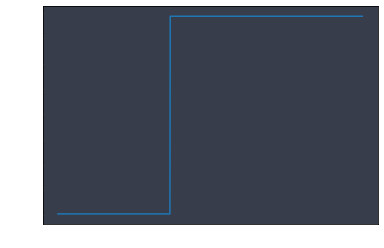

In [27]:
plt.plot(range(len(props)), props)

(array([334.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 572.]),
 array([0.078125 , 0.0796875, 0.08125  , 0.0828125, 0.084375 , 0.0859375,
        0.0875   , 0.0890625, 0.090625 , 0.0921875, 0.09375  ]),
 <BarContainer object of 10 artists>)

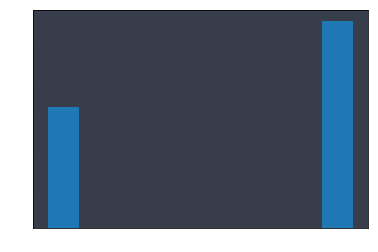

In [19]:
plt.hist(props)

In [44]:
class BatchStratifiedSampler(Sampler):                                                                                                                                        
    """Stratified batch sampler."""                                                                                                                                           
    def __init__(self,                                                                                                                                                        
                 data_source,                                                                                                                                                 
                 indices,                                                                                                                                                     
                 labels,                                                                                                                                                      
                 batch_size,                                                                                                                                                  
                 drop_last=False,                                                                                                                                             
                 random_state=None):                                                                                                                                          
        self.data_source = data_source                                                                                                                                        
        self.indices = indices                                                                                                                                                
        self.labels = labels                                                                                                                                                  
        self.batch_size = batch_size                                                                                                                                          
        self.drop_last = drop_last                                                                                                                                            
        self.random_state = random_state                                                                                                                                      
                                                                                                                                                                              
    def __len__(self):                                                                                                                                                        
        return len(self.indices)                                                                                                                                              
                                                                                                                                                                              
    def __iter__(self):                                                                                                                                                       
        indices = stratify_batches(                                                                                                                                
            self.indices,                                                                                                                                                     
            self.labels,                                                                                                                                                      
            self.batch_size,                                                                                                                                                  
            drop_last=self.drop_last,                                                                                                                                         
            random_state=self.random_state                                                                                                                              
        )                                                                                                                                                                     
        return iter(indices) 

# class BatchStratifiedSampler(Sampler):
#     """Stratified batch sampler."""
#     def __init__(self,
#                  data_source,
#                  indices,
#                  labels,
#                  batch_size,
#                  drop_last=False,
#                  random_state=None):
#         self.data_source = data_source
#         self.indices = indices
#         self.labels = labels
#         self.batch_size = batch_size
#         self.drop_last = drop_last
#         self.random_state = random_state

#     def __len__(self):
#         return len(self.indices)

#     def __iter__(self):
#         indices = stratify_batches(
#             self.indices,
#             self.labels,
#             self.batch_size,
#             drop_last=self.drop_last,
#             random_state=self.random_state
#         )
#         return iter(indices)

In [40]:
from torch.utils.data import RandomSampler, SubsetRandomSampler

In [43]:
sampler = BatchStratifiedSampler(ds, range(len(ds)), labels=ds.get_labels(), batch_size=batch_size)
labels = []
for idx in sampler:
    labels.append(sampler.data_source.df['target'].iloc[idx])
targets = [labels[i*batch_size:(i+1)*batch_size] for i in range(len(labels) // batch_size)]
props = [sum(targets[i])/len(targets[i]) for i in range(len(targets))]
print(f'mean   : {np.mean(props):.4f}')
print(f'std    : {np.std(props):.4f}')
print(f'median : {np.median(props):.
4f}')

48
mean   : 0.0880
std    : 0.0075
median : 0.0938


In [45]:
batch_indices = []
for i in range(len(labels) // batch_size):
    batch_indices.append(labels[i*batch_size:(i+1)*batch_size])
    batch_targets = []
    for idx in batch_indices[i]:
        batch_targets.append(ds[idx])
    targets.append(batch_targets)
    
props = [sum(targets[i])/len(targets[i]) for i in range(len(targets))]

In [49]:
batch_size = 64
ds = MelanomaDataset('../data/ISIC_2020/224x224_jpg_100_4/train/', df_train)
sampler = BatchStratifiedSampler(ds, range(len(ds)), labels=ds.get_labels(), batch_size=batch_size)
dl = DataLoader(ds, batch_size=batch_size, sampler=sampler, drop_last=True, num_workers=1)

targets = []
for y in tqdm(dl):
    targets.append(y.numpy())
    
props = [sum(targets[i])/len(targets[i]) for i in range(len(targets))]

  0%|          | 0/906 [00:00<?, ?it/s]

48


100%|██████████| 906/906 [00:01<00:00, 884.23it/s]


mean   : 0.0879
std    : 0.0076
median : 0.0938


(array([338.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 568.]),
 array([0.078125 , 0.0796875, 0.08125  , 0.0828125, 0.084375 , 0.0859375,
        0.0875   , 0.0890625, 0.090625 , 0.0921875, 0.09375  ]),
 <BarContainer object of 10 artists>)

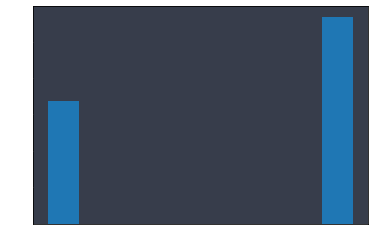

In [50]:
print(f'mean   : {np.mean(props):.4f}')
print(f'std    : {np.std(props):.4f}')
print(f'median : {np.median(props):.4f}')
plt.hist(props)

In [46]:
batch_size = 64
ds = MelanomaDataset('../data/ISIC_2020/224x224_jpg_100_4/train/', df_train)
sampler = ImbalancedSampler(ds)
dl = DataLoader(ds, batch_size=batch_size, sampler=sampler, drop_last=True)

targets = []
for y in tqdm(dl):
    targets.append(y.numpy())
    
props = [sum(targets[i])/len(targets[i]) for i in range(len(targets))]

100%|██████████| 906/906 [00:00<00:00, 4262.00it/s]


mean   : 0.4992
std    : 0.0636
median : 0.5000


(array([ 12.,  19.,  86., 130., 178., 251., 108.,  93.,  23.,   6.]),
 array([0.3125, 0.35  , 0.3875, 0.425 , 0.4625, 0.5   , 0.5375, 0.575 ,
        0.6125, 0.65  , 0.6875]),
 <BarContainer object of 10 artists>)

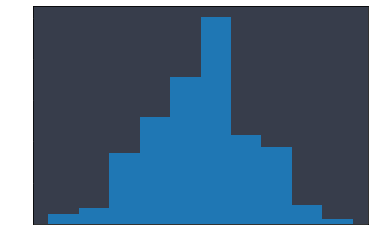

In [47]:
print(f'mean   : {np.mean(props):.4f}')
print(f'std    : {np.std(props):.4f}')
print(f'median : {np.median(props):.4f}')
plt.hist(props)

In [33]:
class ImbalancedSampler(Sampler):

    def __init__(self,
                 dataset,
                 indices=None,
                 num_samples=None,
                 callback_get_label=None):
        # if indices is not provided,
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided,
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices)if num_samples is None else num_samples

        # distribution of classes in the dataset
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1

        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.get_labels()[idx]

    def __iter__(self):
        return (
            self.indices[i]
            for i
            in torch.multinomial(self.weights, self.num_samples, replacement=True)
        )

    def __len__(self):
        return self.num_samples

In [34]:
sampler = ImbalancedSampler(ds)

In [40]:
np.unique(sampler.weights)[1]

0.0001959631589261219

In [41]:
labels = ds.get_labels()

In [62]:
num_samples = len(ds)
labels = ds.get_labels()
num_pos = sum(labels)
num_neg = num_samples - num_pos
pos_rate = num_pos / num_samples
num_oversampled = num_neg * 2
indices = sampler.indices
pos_indices = [idx for idx in indices if labels[idx] == 1]
neg_indices = [idx for idx in indices if labels[idx] == 0]

In [65]:
sampled_pos_indices = np.random.choice(pos_indices, num_neg, replace=True)
new_indices = np.concatenate((neg_indices, sampled_pos_indices))
tmp = [new_indices[i] for i in np.random.choice(range(num_oversampled), num_oversampled, replace=False)]

In [67]:
class Oversampler(Sampler):
    """Oversampler class to balance positive and negative samples."""
    def __init__(self, dataset, indices=None, labels=None):
        self.dataset = dataset
        self.num_samples = len(dataset)
        self.indices = list(range(self.num_samples)) if indices is None else indices
        self.labels = self.dataset.get_labels() if labels is None else labels
        self._label_count = {}
        self._label_indices = {}
        for c in np.unique(self.labels):
            label_indices = [i for i in self.indices if self.labels[i] == c]
            self._label_indices[c] = label_indices
            self._label_count[c] = len(label_indices)
        self._num_oversampled = self._label_count[0] * 2
        
    def __len__(self):
        return self._num_oversampled
    
    def __iter__(self):
        sampled_pos_indices = np.random.choice(self._label_indices[1], 
                                               self._label_count[0], 
                                               replace=True)
        indices = np.concatenate((self._label_indices[0], sampled_pos_indices))
        return (
            indices[i] 
            for i 
            in np.random.choice(range(len(self)), len(self), replace=False)
        )

In [72]:
batch_size = 64
ds = MelanomaDataset('../data/ISIC_2020/224x224_jpg_100_4/train/', df_train)
sampler = Oversampler(ds)
dl = DataLoader(ds, batch_size=batch_size, sampler=sampler, drop_last=True)

targets = []
for y in tqdm(dl):
    targets.append(y.numpy())
    
props = [sum(targets[i])/len(targets[i]) for i in range(len(targets))]

100%|██████████| 1654/1654 [00:00<00:00, 15893.12it/s]


mean   : 0.5000
std    : 0.0624
median : 0.5000


(array([ 31.,  49., 229., 288., 315., 426., 181., 104.,  19.,  12.]),
 array([0.328125, 0.365625, 0.403125, 0.440625, 0.478125, 0.515625,
        0.553125, 0.590625, 0.628125, 0.665625, 0.703125]),
 <BarContainer object of 10 artists>)

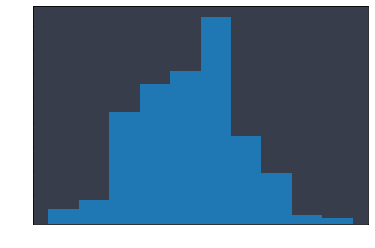

In [73]:
print(f'mean   : {np.mean(props):.4f}')
print(f'std    : {np.std(props):.4f}')
print(f'median : {np.median(props):.4f}')
plt.hist(props)

In [13]:
list(range(0, 200, 16))

[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192]

In [ ]:
3: 32, 80, 128, 176

In [27]:
num_replicas = 4
batch_size = 16
sampler = torch.utils.data.sampler.SequentialSampler(range(200))
num_samples = len(sampler)

In [25]:
68//16 % num_replicas

1

In [28]:
rank = 3
for i in sampler:
    print(i, i//batch_size, i // batch_size % num_replicas)


0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 1 1
17 1 1
18 1 1
19 1 1
20 1 1
21 1 1
22 1 1
23 1 1
24 1 1
25 1 1
26 1 1
27 1 1
28 1 1
29 1 1
30 1 1
31 1 1
32 2 2
33 2 2
34 2 2
35 2 2
36 2 2
37 2 2
38 2 2
39 2 2
40 2 2
41 2 2
42 2 2
43 2 2
44 2 2
45 2 2
46 2 2
47 2 2
48 3 3
49 3 3
50 3 3
51 3 3
52 3 3
53 3 3
54 3 3
55 3 3
56 3 3
57 3 3
58 3 3
59 3 3
60 3 3
61 3 3
62 3 3
63 3 3
64 4 0
65 4 0
66 4 0
67 4 0
68 4 0
69 4 0
70 4 0
71 4 0
72 4 0
73 4 0
74 4 0
75 4 0
76 4 0
77 4 0
78 4 0
79 4 0
80 5 1
81 5 1
82 5 1
83 5 1
84 5 1
85 5 1
86 5 1
87 5 1
88 5 1
89 5 1
90 5 1
91 5 1
92 5 1
93 5 1
94 5 1
95 5 1
96 6 2
97 6 2
98 6 2
99 6 2
100 6 2
101 6 2
102 6 2
103 6 2
104 6 2
105 6 2
106 6 2
107 6 2
108 6 2
109 6 2
110 6 2
111 6 2
112 7 3
113 7 3
114 7 3
115 7 3
116 7 3
117 7 3
118 7 3
119 7 3
120 7 3
121 7 3
122 7 3
123 7 3
124 7 3
125 7 3
126 7 3
127 7 3
128 8 0
129 8 0
130 8 0
131 8 0
132 8 0
133 8 0
134 8 0
135 8 0
136 8 0
137 8 0
138 8 

In [ ]:
[e for i, e in enumerate(self.iterable) if (i - self.rank) % self.num_replicas == 0]

In [ ]:
[e for i, e in enumerate(self.iterable) if (i // self.batch_size) % self.num_replicas == self.rank]